# Dikemodel continued - subspace partitioning

Scenario discovery.... (nog uitleg toevoegen)

## 1. Apply scenario discovery

**1.** Import model from Open Exploration

In [1]:
from lakemodel_function import lake_problem

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation2 import get_model_for_problem_formulation, sum_over, sum_over_time

**2.** Import results from Open Exploration

In [1]:
from OpenExploration import results

ModuleNotFoundError: No module named 'OpenExploration'

**3.** The experiments array contains the values for each of the 100 decision levers. This might easily mess up the analysis. Remove these columns from the experiment array. *hint: use `experiments.drop`*

In [4]:
experiments, outcomes = results

In [5]:
cleaned_experiments = experiments.drop(labels=[l.name for l in lake_model.levers], axis=1)

**3.** Apply scenario discovery, focussing on the 10 percent of worst outcomes for reliability

In [6]:
from ema_workbench.analysis import prim

data = outcomes['reliability']

y = data < np.percentile(data, 10)

prim_alg = prim.Prim(cleaned_experiments,y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 10000 points remaining, containing 1000 cases of interest
[MainProcess/INFO] mean: 0.9424603174603174, mass: 0.0504, coverage: 0.475, density: 0.9424603174603174 restricted_dimensions: 5


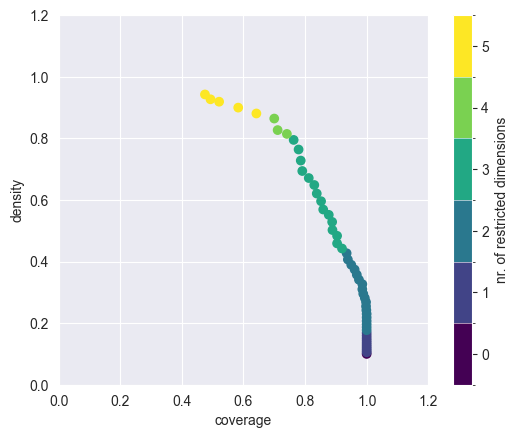

In [7]:
box1.show_tradeoff()
plt.show()

This figure shows the trade-off between coverage, density, and the number of restricted dimensions (i.e., a proxy for interpretability). Each dot corresponds to one candidate box. As an analyst, it is up to you to choose which box you want to inspect in more detail. Here you have to balance the three objectives. There is no hard rule that is used here. Note, however, that a density of lower than 0.5 means that less than half of the cases within the box of interest are of interest. So ideally, you start with higher density boxes. Moreover, you want boxes for which the box limits are statistically significant according to the quasi p-values. This means that the last box for a given number of restricted dimensions is also a good candidate box to inspect (here, for example, the last box with 2 dimensions and the last box with 3 dimensions).

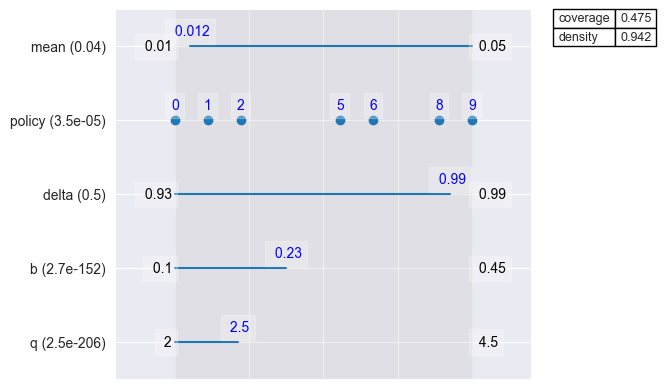

In [8]:
box1.inspect(style='graph')
plt.show()

This figure shows in gray the complete interval for each parameter. A blue line is used in the case of RealParameters to show the interval of the box identified by PRIM. For CategoricalParameters, a dot is used instead. The blue numbers give the specific limit. The numbers behind the y-labels indicate the quasi p-values. In the top right-hand corner, you can see the coverage and density of the identified box. So, what do we see in this case. First, both delta and stdev are not significant and should be ignored in the interpretation. This leaves b, q, and some of the policies as the key determinants. So, our top 10% worst performance for reliability occurs if b and q are low and for 6 out of the 10 policies. This covers 56% of the cases of interest, with a precision (i.e. density) of 80%. Now, you would go back to the model and try to understand why you get low reliability if b and q are low.

## 2. Visualize the results using Dimensional Stacking
Take the classification of outcomes as used in step 3 of scenario discovery, and instead visualize the results using dimensional stacking. How do these results compare to the insights from scenario discovery?

In [9]:
from ema_workbench.analysis import dimensional_stacking

[MainProcess/INFO] model dropped from analysis because only a single category


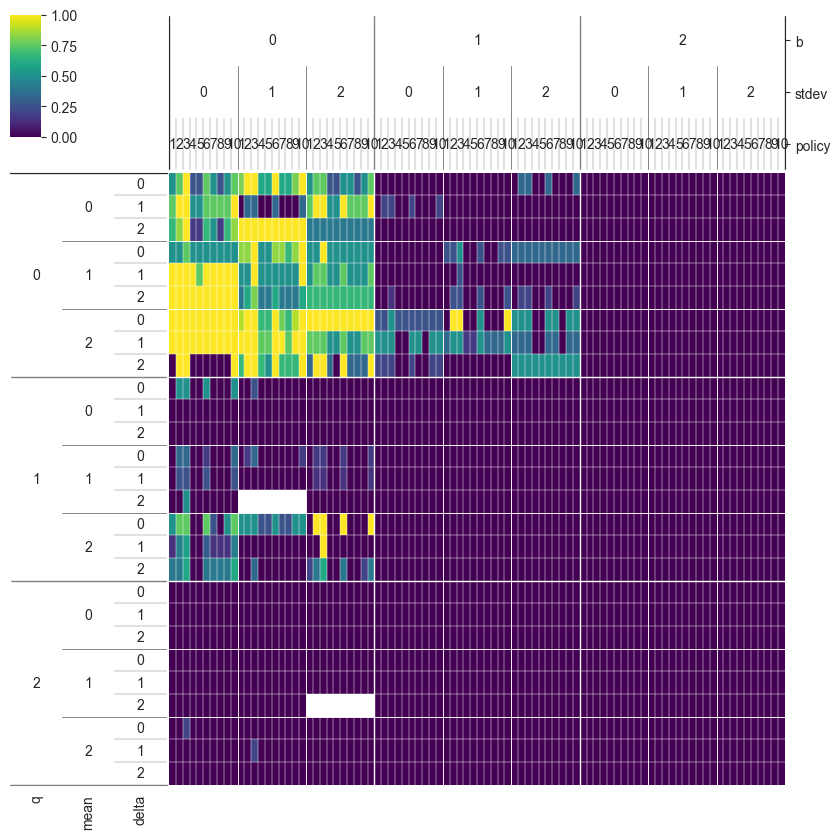

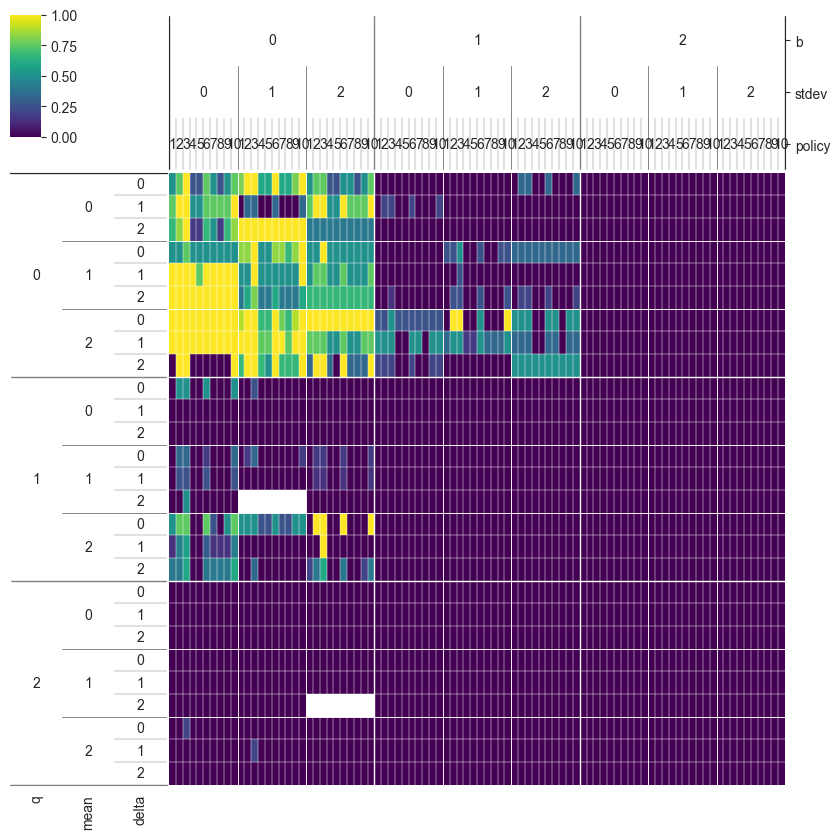

In [10]:
dimensional_stacking.create_pivot_plot(cleaned_experiments, y)

looking at this graph, we have a few white spaces, so there is an argument to be made that we should run quite a bit more than 1000 runs.

In [11]:
n_scenarios = 10000
n_policies = 10

with MultiprocessingEvaluator(lake_model, n_processes=-1) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, n_policies)

[MainProcess/INFO] pool started with 7 workers
[MainProcess/INFO] performing 10000 scenarios * 10 policies * 1 model(s) = 100000 experiments
100%|████████████████████████████████| 100000/100000 [00:32<00:00, 3123.67it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


[MainProcess/INFO] model dropped from analysis because only a single category


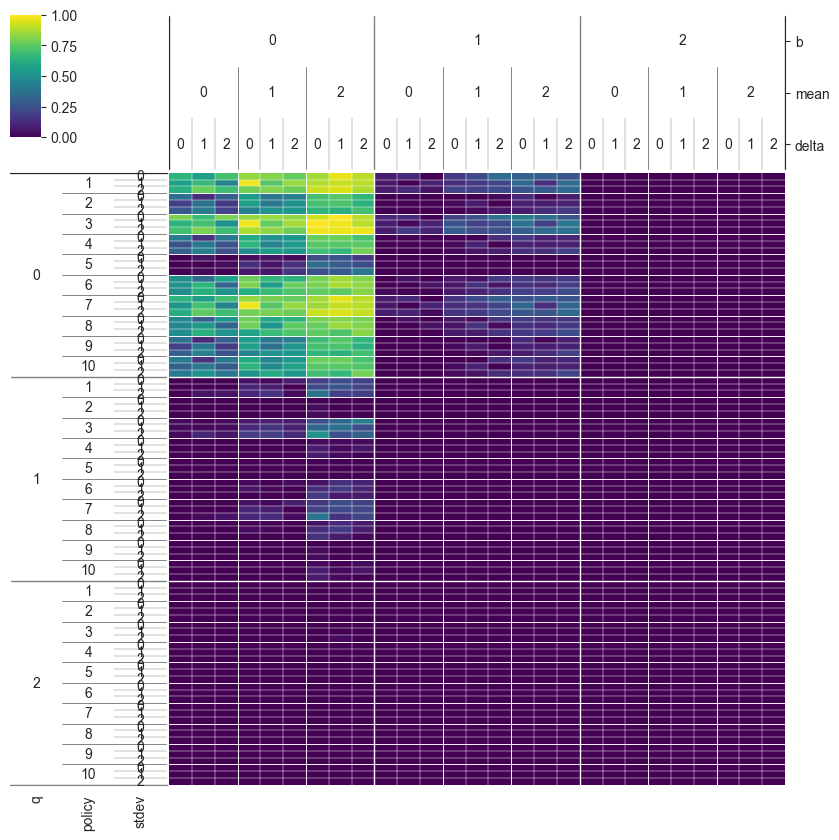

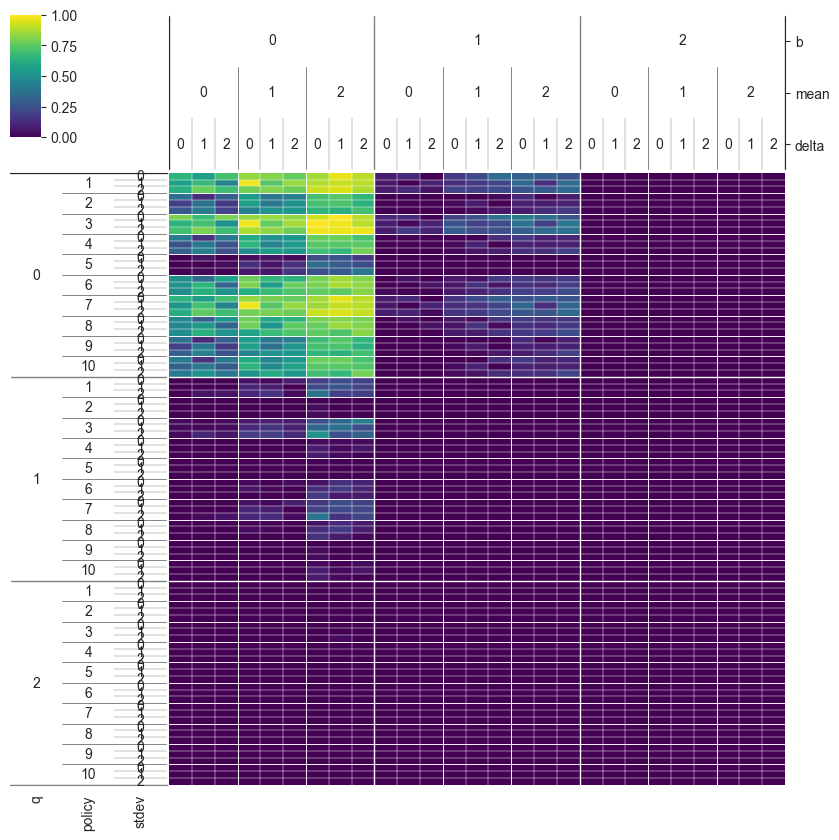

In [12]:
experiments, outcomes = results
cleaned_experiments = experiments.drop(labels=[l.name for l in lake_model.levers], axis=1)

data = outcomes['reliability']
y = data < np.percentile(data, 10)

dimensional_stacking.create_pivot_plot(cleaned_experiments, y)

As you can see, with the additional runs there are at least no white spaces left anymore. This is a good indication that we have a good coverage of the space.

#### Concluding remarks
In this notebook, we have applied several techniques for scenario discovery to the inter temporal version of the lake problem (i.e., the one with 100 decision variables). Both dimensional stacking and PRIM point to the importance of low values for the b and q parameters in driving low reliability. The last, qualitative, step is to go back to the model and offer a structural explanation (remember from system dynamics: structure explains behavior) for this behavior. So why do you get low reliability of b and q are low?